In [1]:
import os
from pathlib import Path
import random

import librosa
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Path to the dataset (relative to the notebook)
DATA_ROOT = Path("../data")

# Audio and feature configuration
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Patch configuration
PATCH_FRAMES = 64      # number of time frames per patch
PATCH_HOP = 32         # hop size between consecutive patches (for sliding windows)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device("cuda")
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device("cpu")

print("Using device:", device)

PyTorch version: 2.9.1+cu126
CUDA available: True
Number of CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


### Scanning the dataset folder

This code searches through the `../data` directory and builds a list of all audio files.
For every `.wav` file, it records:

- the file path  
- the machine type (fan, pump, slider, etc.)  
- whether it belongs to the training or test split  
- a label:  
  - `0` for normal  
  - `1` for anomaly  
  - `None` if the filename does not specify this

The result is a structured list that we can use to build datasets later.

In [2]:
def scan_files(data_root=DATA_ROOT, machine_types=None):
    """
    Scan ../data and return a list of dictionaries containing:
    {
        'path': Path,
        'machine_type': str,
        'split': 'train' or 'test',
        'label': 0 (normal) or 1 (anomaly)
    }
    """
    if machine_types is None:
        machine_types = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

    all_files = []

    for mtype in machine_types:
        for split in ["train", "test"]:
            split_dir = data_root / mtype / split
            if not split_dir.exists():
                continue

            for fname in sorted(split_dir.glob("*.wav")):
                name_lower = fname.name.lower()

                if "normal" in name_lower:
                    label = 0
                elif "anomaly" in name_lower:
                    label = 1
                else:
                    # fallback if the filename does not explicitly specify the class
                    label = None

                all_files.append({
                    "path": fname,
                    "machine_type": mtype,
                    "split": split,
                    "label": label,
                })

    return all_files


file_list = scan_files()
len(file_list), file_list[:5]

(30987,
 [{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0}])

### Loading audio and converting it to a log-Mel spectrogram

This code defines two helper functions:

1. `load_audio(path)`  
   - Loads an audio file using librosa.  
   - Converts it to mono and resamples it to the chosen sample rate.

2. `audio_to_logmelspec(y)`  
   - Converts the waveform into a Mel spectrogram.  
   - Applies a logarithm to compress the dynamic range.  
   - Returns a 2D array with shape `(n_mels, n_frames)`.

These functions prepare the raw audio so that it can be used as input for the neural network.

In [3]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file as mono at a fixed sample rate.

    Returns:
        audio: np.ndarray, shape (samples,)
        sr   : int, sample rate
    """
    audio, sr = librosa.load(path, sr=sr, mono=True)
    return audio, sr


def audio_to_logmelspec(
    audio,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert a waveform into a log-Mel spectrogram.
    audio : 1D numpy array
    sr    : sample rate

    Returns:
        log-Mel spectrogram of shape (n_mels, n_frames)
    """
    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    logS = np.log(S + 1e-12)
    return logS

### Splitting a spectrogram into patches and preparing batches

This code performs two tasks:

1. `spec_to_patches(spec)`  
   - Takes a full log-Mel spectrogram.  
   - Splits it into smaller segments (patches) with a fixed number of time frames.  
   - Uses a sliding window so patches can overlap.  
   - Returns an array of shape `(num_patches, n_mels, patch_frames)`.

2. `collate_patches_with_meta(batch)`  
   - Custom DataLoader collate function.  
   - Combines all patch tensors in a batch into one tensor.  
   - Keeps metadata dictionaries as a separate list (not merged).  
   - This avoids errors because PyTorch cannot automatically collate dictionaries with Path objects.

These functions prepare spectrogram data so it can be fed efficiently into the neural network during training.


In [4]:
def spec_to_patches(spec, patch_frames=PATCH_FRAMES, patch_hop=PATCH_HOP):
    """
    Convert a spectrogram into overlapping patches.

    Parameters:
        spec : np.array of shape (n_mels, n_frames)
        patch_frames : number of time frames per patch
        patch_hop : hop size between consecutive patches

    Returns:
        np.array of shape (n_patches, n_mels, patch_frames)
    """
    n_mels, n_frames = spec.shape

    # If the spectrogram is shorter than the required patch length, pad it with zeros
    if n_frames < patch_frames:
        pad_width = patch_frames - n_frames
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
        n_frames = spec.shape[1]

    patches = []
    for start in range(0, n_frames - patch_frames + 1, patch_hop):
        end = start + patch_frames
        patch = spec[:, start:end]
        patches.append(patch)

    patches = np.stack(patches, axis=0)
    return patches


def collate_patches_with_meta(batch):
    """
    Custom collate function for DataLoader.

    Parameters:
        batch : list of (patch_tensor, meta_dict)

    Returns:
        patches : tensor of shape [B, 1, n_mels, patch_frames]
        metas   : tuple or list of metadata dictionaries (not collated)
    """
    patches, metas = zip(*batch)
    patches = torch.stack(patches, dim=0)
    return patches, metas

In [5]:
class DCASETrainPatchDataset(Dataset):
    """
    Dataset used to train the autoencoder.

    It uses only normal training files (split == 'train' and label == 0).

    For each item:
        - load the audio file,
        - compute the log-Mel spectrogram,
        - split it into patches,
        - randomly select one patch,
        - return it along with metadata.
    """

    def __init__(
        self,
        file_list,
        machine_type=None,
        val_split=0.2,
        split="train",      # 'train' or 'val'
        normalize=True,
    ):
        # Select only normal training files
        candidates = [
            f for f in file_list
            if f["split"] == "train" and f["label"] == 0
        ]

        # Optional: filter by machine type
        if machine_type is not None:
            candidates = [
                f for f in candidates
                if f["machine_type"] == machine_type
            ]

        # Train/validation split at the file level
        random.shuffle(candidates)
        n_total = len(candidates)
        n_val = int(n_total * val_split)

        val_files = candidates[:n_val]
        train_files = candidates[n_val:]

        if split == "train":
            self.files = train_files
        elif split == "val":
            self.files = val_files
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.normalize = normalize

        # Normalization statistics (mean and standard deviation)
        self.mean_ = 0.0
        self.std_ = 1.0

        # Fit normalization on the training set only
        if normalize and split == "train":
            self._fit_normalization(train_files)

    def _fit_normalization(self, files_subset):
        """
        Compute an approximate mean and standard deviation over all patches
        in a subset of training files. This is sufficient for a first version.
        """
        print("Fitting normalization (mean/std) over a subset of training data...")
        values = []

        for f in files_subset:
            # UNPACK audio and sr
            audio, sr = load_audio(f["path"])
            # Pas deze call aan als jouw functie andere args verwacht
            spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
            # idem: gebruik jouw eigen signatuur van spec_to_patches
            patches = spec_to_patches(
                spec,
                patch_frames=PATCH_FRAMES,
                patch_hop=PATCH_HOP,
            )

            # Flatten patches and collect values
            values.append(patches.reshape(-1))

        values = np.concatenate(values, axis=0)
        self.mean_ = float(values.mean())
        self.std_ = float(values.std() + 1e-6)

        print(f"mean={self.mean_:.4f}, std={self.std_:.4f}")

    def __len__(self):
        # Each file corresponds to one dataset element, but each call returns a different random patch
        return len(self.files)

    def __getitem__(self, idx):
        meta = self.files[idx]

        # UNPACK audio and sr
        audio, sr = load_audio(meta["path"])
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(
            spec,
            patch_frames=PATCH_FRAMES,
            patch_hop=PATCH_HOP,
        )

        # Randomly select a patch
        if patches.shape[0] == 0:
            # fallback: leeg audio → dummy patch
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            p_idx = np.random.randint(0, patches.shape[0])
            patch = patches[p_idx]  # verwacht vorm (N_MELS, PATCH_FRAMES)

        # Normalize if enabled
        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        # Convert to tensor with shape (1, n_mels, patch_frames)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)

        return patch_tensor, meta

In [6]:
train_dataset = DCASETrainPatchDataset(file_list, machine_type="fan", split="train")
val_dataset = DCASETrainPatchDataset(file_list, machine_type="fan", split="val",
                                     normalize=train_dataset.normalize)

Fitting normalization (mean/std) over a subset of training data...
mean=-6.9173, std=2.0605


In [7]:
# Copy mean and standard deviation from the training dataset to the validation dataset
val_dataset.mean_ = train_dataset.mean_
val_dataset.std_ = train_dataset.std_

# DataLoader for training
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_patches_with_meta,
)

# DataLoader for validation
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)


In [8]:
class DCASETestPatchDataset(Dataset):
    """
    Dataset for evaluating the autoencoder on test data.

    Each item returns:
        - one random spectrogram patch (tensor of shape (1, n_mels, patch_frames)),
        - metadata dict including 'label'.
    """
    def __init__(
        self,
        file_list,
        machine_type=None,
        normalize=True,
        mean_=0.0,
        std_=1.0,
    ):
        # Select test files with valid labels
        self.files = [
            f for f in file_list
            if f["split"] == "test" and f["label"] is not None
        ]

        if machine_type is not None:
            self.files = [
                f for f in self.files
                if f["machine_type"] == machine_type
            ]

        self.normalize = normalize
        self.mean_ = mean_
        self.std_ = std_

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        info = self.files[idx]
        path = info["path"]
        label = info["label"]     # 0 or 1

        # Load audio + spectrogram
        audio, sr = load_audio(path)
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(
            spec,
            patch_frames=PATCH_FRAMES,
            patch_hop=PATCH_HOP,
        )

        # Choose one random patch (or fallback to zeros)
        if patches.shape[0] == 0:
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            i = np.random.randint(0, patches.shape[0])
            patch = patches[i]  # (n_mels, patch_frames)

        # Normalize
        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)  # (1, n_mels, T)

        meta = {
            "path": str(path),
            "machine_type": info["machine_type"],
            "split": info["split"],
            "label": int(label),
            "machine_id": info.get("machine_id", None),
        }

        # BELANGRIJK: alleen (patch_tensor, meta), GEEN losse label meer
        return patch_tensor, meta

In [9]:
# Test dataset (fan only, normalized with train mean/std)
test_dataset = DCASETestPatchDataset(
    file_list,
    machine_type="fan",
    normalize=True,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)


In [10]:
import re

def add_machine_ids(file_list):
    """
    Add a 'machine_id' integer to each file dict, parsed from the filename.

    Assumes DCASE-style filenames like: fan_id_00_00000000.wav
    => machine_id = 0 (from 'id_00')
    """
    for item in file_list:
        name = item["path"].name  # e.g. fan_id_00_00000000.wav
        m = re.search(r"id_(\d+)", name)
        if m:
            item["machine_id"] = int(m.group(1))
        else:
            item["machine_id"] = None
    return file_list


# Run the function immediately
file_list = add_machine_ids(file_list)

# Quick sanity check
[file_list[i] for i in range(5)]

[{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0,
  'machine_id': 0}]

In [11]:
def patches_to_sequence(patches):
    """
    Convert patches from CNN format to (B, T, F) = (batch, time, n_mels).

    Expected input shapes:
      - (B, 1, n_mels, patch_frames)
      - or (B, n_mels, patch_frames)

    Returns:
      - (B, T, F) where T = patch_frames, F = n_mels
    """
    if patches.dim() == 4:
        # (B, 1, n_mels, patch_frames)
        B, C, F, T = patches.shape
        if C != 1:
            raise ValueError(f"Expected C=1, got {C}")
        x = patches.squeeze(1)          # (B, n_mels, T)
        x = x.permute(0, 2, 1)          # (B, T, n_mels)
        return x
    elif patches.dim() == 3:
        # (B, n_mels, patch_frames)
        x = patches.permute(0, 2, 1)    # (B, T, n_mels)
        return x
    else:
        raise ValueError(f"Unexpected patch shape: {patches.shape}")


def get_center_index(num_frames: int) -> int:
    """
    Return center time index given T frames.
    Uses floor(T / 2).
    """
    return num_frames // 2


# Quick test: run the helpers on a dummy batch
dummy = torch.randn(4, 1, N_MELS, PATCH_FRAMES)
seq = patches_to_sequence(dummy)       # should be (4, PATCH_FRAMES, N_MELS)
print("dummy shape:", dummy.shape)
print("seq shape:", seq.shape)
print("center index:", get_center_index(seq.shape[1]))


dummy shape: torch.Size([4, 1, 128, 64])
seq shape: torch.Size([4, 64, 128])
center index: 32


In [12]:
def get_num_machines_for_type(file_list, machine_type="fan"):
    """
    Compute number of distinct machine IDs for a given machine type.
    """
    ids = sorted({
        f["machine_id"]
        for f in file_list
        if f["machine_type"] == machine_type and f.get("machine_id") is not None
    })
    if not ids:
        raise ValueError(f"No machine_id found for type {machine_type}")
    return max(ids) + 1


NUM_MACHINES_FAN = get_num_machines_for_type(file_list, machine_type="fan")
NUM_MACHINES_FAN

7

In [13]:
class IDCTransAE(nn.Module):
    def __init__(
        self,
        n_mels: int,
        num_machines: int,
        d_model: int = 128,
        n_heads: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
    ):
        """
        ID-conditioned Transformer autoencoder for center-frame prediction.

        Input:
          - patches: (B, 1, n_mels, patch_frames)
        Output:
          - recon_center : (B, n_mels)
          - id_logits    : (B, num_machines)
          - patch_errors : (B,)  [optional, if return_patch_errors=True]
        """
        super().__init__()

        self.n_mels = n_mels
        self.num_machines = num_machines
        self.d_model = d_model

        # Frame embedding: each frame (n_mels) -> d_model
        self.frame_embed = nn.Linear(n_mels, d_model)

        # Positional embedding (time index)
        self.max_len = 512
        self.pos_embed = nn.Embedding(self.max_len, d_model)

        # Machine-ID embedding (conditioning)
        self.id_embed = nn.Embedding(num_machines, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False,  # we use (T, B, d_model)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Reconstruction head: latent -> center frame
        self.recon_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_mels),
        )

        # Machine-ID classifier head: latent -> ID logits
        self.id_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_machines),
        )

    def forward(self, patches, machine_ids, return_patch_errors=False):
        """
        patches    : (B, 1, n_mels, patch_frames)
        machine_ids: (B,) long

        Returns:
          recon_center : (B, n_mels)
          id_logits    : (B, num_machines)
          patch_errors : (B,)  # if return_patch_errors=True
        """
        # Convert to (B, T, n_mels)
        x = patches_to_sequence(patches)  # (B, T, n_mels)
        B, T, n_mels_ = x.shape
        assert n_mels_ == self.n_mels, f"Expected n_mels={self.n_mels}, got {n_mels_}"

        center_idx = get_center_index(T)

        # Mask center frame
        x_masked = x.clone()
        x_masked[:, center_idx, :] = 0.0

        # Frame embedding
        h = self.frame_embed(x_masked)  # (B, T, d_model)

        # Positional embedding
        positions = torch.arange(T, device=h.device).unsqueeze(0)  # (1, T)
        pos_emb = self.pos_embed(positions)  # (1, T, d_model)

        # Machine-ID embedding (broadcast over time)
        id_emb = self.id_embed(machine_ids).unsqueeze(1)  # (B, 1, d_model)
        id_emb = id_emb.expand(-1, T, -1)                 # (B, T, d_model)

        # Combine embeddings
        h = h + pos_emb + id_emb  # (B, T, d_model)

        # TransformerEncoder expects (T, B, d_model)
        h = h.permute(1, 0, 2)    # (T, B, d_model)
        h_enc = self.encoder(h)   # (T, B, d_model)

        # Center latent
        h_center = h_enc[center_idx, :, :]  # (B, d_model)

        # Reconstruction and ID logits
        recon_center = self.recon_head(h_center)  # (B, n_mels)
        id_logits = self.id_head(h_center)        # (B, num_machines)

        if return_patch_errors:
            # Target center frame
            x_full = patches_to_sequence(patches)         # (B, T, n_mels)
            target_center = x_full[:, center_idx, :]      # (B, n_mels)

            per_frame_mse = F.mse_loss(
                recon_center, target_center, reduction="none"
            )  # (B, n_mels)
            patch_errors = per_frame_mse.mean(dim=1)      # (B,)
            return recon_center, id_logits, patch_errors

        return recon_center, id_logits

In [14]:
# Instantiate and run on a dummy batch
idc_model = IDCTransAE(
    n_mels=N_MELS,
    num_machines=NUM_MACHINES_FAN,
    d_model=128,
    n_heads=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
).to(device)

dummy_patches = torch.randn(8, 1, N_MELS, PATCH_FRAMES, device=device)
dummy_machine_ids = torch.zeros(8, dtype=torch.long, device=device)

recon_center, id_logits, patch_errors = idc_model(
    dummy_patches,
    dummy_machine_ids,
    return_patch_errors=True,
)

print("recon_center:", recon_center.shape)
print("id_logits   :", id_logits.shape)
print("patch_errors:", patch_errors.shape)

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


recon_center: torch.Size([8, 128])
id_logits   : torch.Size([8, 7])
patch_errors: torch.Size([8])


In [15]:
def idc_loss(recon_center, target_center, id_logits, machine_ids, alpha_id=1.0):
    """
    Combined reconstruction + ID classification loss.
    """
    recon_loss = F.mse_loss(recon_center, target_center)
    id_loss = F.cross_entropy(id_logits, machine_ids)
    total_loss = recon_loss + alpha_id * id_loss
    return total_loss, float(recon_loss.item()), float(id_loss.item())


def train_idc_epoch(
    model,
    loader,
    optimizer,
    device,
    alpha_id=1.0,
    max_batches=None,
):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_id = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)

        # machine_ids from metadata
        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        # Target center frame
        x_seq = patches_to_sequence(patch_batch)  # (B, T, n_mels)
        center_idx = get_center_index(x_seq.shape[1])
        target_center = x_seq[:, center_idx, :]   # (B, n_mels)

        optimizer.zero_grad()
        recon_center, id_logits = model(patch_batch, machine_ids)

        loss, recon_l, id_l = idc_loss(
            recon_center,
            target_center,
            id_logits,
            machine_ids,
            alpha_id=alpha_id,
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_l
        total_id += id_l
        n_batches += 1

    if n_batches == 0:
        return {}

    return {
        "loss": total_loss / n_batches,
        "recon_loss": total_recon / n_batches,
        "id_loss": total_id / n_batches,
    }


@torch.no_grad()
def eval_idc_epoch(
    model,
    loader,
    device,
    alpha_id=1.0,
    max_batches=None,
):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_id = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)
        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        x_seq = patches_to_sequence(patch_batch)
        center_idx = get_center_index(x_seq.shape[1])
        target_center = x_seq[:, center_idx, :]

        recon_center, id_logits = model(patch_batch, machine_ids)
        loss, recon_l, id_l = idc_loss(
            recon_center,
            target_center,
            id_logits,
            machine_ids,
            alpha_id=alpha_id,
        )

        total_loss += loss.item()
        total_recon += recon_l
        total_id += id_l
        n_batches += 1

    if n_batches == 0:
        return {}

    return {
        "loss": total_loss / n_batches,
        "recon_loss": total_recon / n_batches,
        "id_loss": total_id / n_batches,
    }


# Quick smoke test: run 1 batch of train/val
optimizer_idc = torch.optim.Adam(idc_model.parameters(), lr=1e-3)

train_stats_test = train_idc_epoch(
    idc_model, train_loader, optimizer_idc, device,
    alpha_id=1.0, max_batches=1,
)
val_stats_test = eval_idc_epoch(
    idc_model, val_loader, device,
    alpha_id=1.0, max_batches=1,
)

print("Train stats (1 batch):", train_stats_test)
print("Val   stats (1 batch):", val_stats_test)


Train stats (1 batch): {'loss': 3.0206990242004395, 'recon_loss': 1.1123777627944946, 'id_loss': 1.9083213806152344}
Val   stats (1 batch): {'loss': 2.46075177192688, 'recon_loss': 1.0326850414276123, 'id_loss': 1.4280667304992676}


In [16]:
from collections import defaultdict

def global_weighted_rank_pooling(errors, r=0.9):
    """
    Global Weighted Rank Pooling (GWRP).

    errors: 1D tensor or list of scalar scores.
    r     : decay factor in (0, 1]; smaller r puts more weight on top scores.
    """
    if isinstance(errors, list):
        errors = torch.tensor(errors, dtype=torch.float32)

    sorted_err, _ = torch.sort(errors, descending=True)
    n = sorted_err.numel()
    if n == 0:
        return 0.0

    weights = torch.pow(torch.full((n,), r, dtype=torch.float32), torch.arange(n))
    weights = weights / weights.sum()

    return torch.sum(sorted_err * weights).item()


def group_patch_scores_by_recording(patch_results, aggregation="gwrp", r=0.9):
    """
    patch_results: list of dicts with keys:
        - "path": identifier of the recording
        - "label": 0 or 1
        - "error": scalar patch score

    Returns:
        recording_scores: dict[path] = {"score": float, "label": int}
    """
    per_file_errors = defaultdict(list)
    per_file_labels = {}

    for item in patch_results:
        path = item["path"]
        per_file_errors[path].append(item["error"])
        if "label" in item:
            per_file_labels[path] = int(item["label"])

    recording_scores = {}
    for path, errors in per_file_errors.items():
        errors_t = torch.tensor(errors, dtype=torch.float32)
        if aggregation == "mean":
            score = errors_t.mean().item()
        elif aggregation == "max":
            score = errors_t.max().item()
        elif aggregation == "gwrp":
            score = global_weighted_rank_pooling(errors_t, r=r)
        else:
            raise ValueError(f"Unknown aggregation: {aggregation}")

        recording_scores[path] = {
            "score": float(score),
            "label": per_file_labels.get(path, 0),
        }

    return recording_scores


def summarize_recording_scores(recording_scores, title=""):
    scores_normal = [v["score"] for v in recording_scores.values() if v["label"] == 0]
    scores_anom   = [v["score"] for v in recording_scores.values() if v["label"] == 1]

    print(f"=== {title} ===")
    print("Total recordings:", len(recording_scores))
    if scores_normal:
        print(
            f"Normal : N={len(scores_normal)}, "
            f"mean={np.mean(scores_normal):.4f}, std={np.std(scores_normal):.4f}"
        )
    if scores_anom:
        print(
            f"Anomaly: N={len(scores_anom)}, "
            f"mean={np.mean(scores_anom):.4f}, std={np.std(scores_anom):.4f}"
        )


# Quick test of GWRP
test_errors = [0.1, 0.2, 0.3, 1.0]
print("GWRP example:", global_weighted_rank_pooling(test_errors, r=0.9))


GWRP example: 0.43759816884994507


In [17]:
@torch.no_grad()
def compute_idc_patch_errors_test(model, loader, device):
    """
    Compute patch-wise center-frame errors for IDC-TransAE on the test set.

    loader should yield: (patch_batch, meta_batch),
    where each meta contains 'label' and 'machine_id'.
    """
    model.eval()
    patch_results = []

    for patch_batch, meta_batch in loader:
        patch_batch = patch_batch.to(device)

        machine_ids = torch.tensor(
            [m["machine_id"] for m in meta_batch],
            dtype=torch.long,
            device=device,
        )

        labels = np.array(
            [m["label"] for m in meta_batch],
            dtype=np.int64,
        )

        # Forward with patch errors
        _, _, patch_errors = model(
            patch_batch,
            machine_ids,
            return_patch_errors=True,
        )  # (B,)

        patch_errors = patch_errors.cpu().numpy()

        for err, label, meta in zip(patch_errors, labels, meta_batch):
            patch_results.append({
                "path": meta["path"],
                "label": int(label),
                "error": float(err),
            })

    return patch_results

# Quick smoke test on a few batches
test_patch_results_small = compute_idc_patch_errors_test(
    idc_model, test_loader, device
)
len(test_patch_results_small), test_patch_results_small[:3]


(1875,
 [{'path': '..\\data\\fan\\test\\anomaly_id_00_00000000.wav',
   'label': 1,
   'error': 1.245903730392456},
  {'path': '..\\data\\fan\\test\\anomaly_id_00_00000001.wav',
   'label': 1,
   'error': 1.3298349380493164},
  {'path': '..\\data\\fan\\test\\anomaly_id_00_00000002.wav',
   'label': 1,
   'error': 0.9719238877296448}])

In [18]:
# Aggregate patch scores into recording scores (e.g. using GWRP)
test_recording_scores_idc = group_patch_scores_by_recording(
    test_patch_results_small,
    aggregation="gwrp",
    r=0.9,
)

summarize_recording_scores(
    test_recording_scores_idc,
    title="Fan test (IDC-TransAE)",
)


=== Fan test (IDC-TransAE) ===
Total recordings: 1875
Normal : N=400, mean=1.0511, std=0.3480
Anomaly: N=1475, mean=1.0714, std=0.3852


In [19]:
from sklearn import metrics

NUM_EPOCHS = 30
ALPHA_ID = 1.0  # weight for ID classification loss

idc_model = IDCTransAE(
    n_mels=N_MELS,
    num_machines=NUM_MACHINES_FAN,
    d_model=128,
    n_heads=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
).to(device)

optimizer_idc = torch.optim.Adam(idc_model.parameters(), lr=1e-3)

for epoch in range(1, NUM_EPOCHS + 1):
    train_stats = train_idc_epoch(
        idc_model,
        train_loader,
        optimizer_idc,
        device,
        alpha_id=ALPHA_ID,
        max_batches=None,  # volledige epoch
    )
    val_stats = eval_idc_epoch(
        idc_model,
        val_loader,
        device,
        alpha_id=ALPHA_ID,
        max_batches=None,
    )

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_stats['loss']:.4f} "
        f"(recon={train_stats['recon_loss']:.4f}, id={train_stats['id_loss']:.4f}) | "
        f"val_loss={val_stats['loss']:.4f} "
        f"(recon={val_stats['recon_loss']:.4f}, id={val_stats['id_loss']:.4f})"
    )


c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 01] train_loss=0.2999 (recon=0.2412, id=0.0587) | val_loss=0.1746 (recon=0.1743, id=0.0003)
[Epoch 02] train_loss=0.1662 (recon=0.1660, id=0.0002) | val_loss=0.1575 (recon=0.1574, id=0.0002)
[Epoch 03] train_loss=0.1533 (recon=0.1531, id=0.0001) | val_loss=0.1462 (recon=0.1462, id=0.0001)
[Epoch 04] train_loss=0.1438 (recon=0.1437, id=0.0001) | val_loss=0.1387 (recon=0.1387, id=0.0000)
[Epoch 05] train_loss=0.1399 (recon=0.1398, id=0.0000) | val_loss=0.1393 (recon=0.1393, id=0.0000)
[Epoch 06] train_loss=0.1593 (recon=0.1536, id=0.0057) | val_loss=0.1472 (recon=0.1472, id=0.0000)
[Epoch 07] train_loss=0.1432 (recon=0.1432, id=0.0001) | val_loss=0.1362 (recon=0.1362, id=0.0000)
[Epoch 08] train_loss=0.1397 (recon=0.1397, id=0.0000) | val_loss=0.1340 (recon=0.1339, id=0.0000)
[Epoch 09] train_loss=0.1356 (recon=0.1355, id=0.0000) | val_loss=0.1325 (recon=0.1325, id=0.0000)
[Epoch 10] train_loss=0.1335 (recon=0.1335, id=0.0000) | val_loss=0.1308 (recon=0.1308, id=0.0000)
[Epoch 11]

In [20]:
test_patch_results = compute_idc_patch_errors_test(idc_model, test_loader, device)
test_recording_scores_idc = group_patch_scores_by_recording(
    test_patch_results,
    aggregation="gwrp",
    r=0.9,
)
summarize_recording_scores(test_recording_scores_idc, title="Fan test (IDC-TransAE)")

=== Fan test (IDC-TransAE) ===
Total recordings: 1875
Normal : N=400, mean=0.1318, std=0.0357
Anomaly: N=1475, mean=0.1450, std=0.0391


In [21]:
def scores_and_labels_from_recording_scores(recording_scores):
    paths = sorted(recording_scores.keys())
    scores = np.array([recording_scores[p]["score"] for p in paths], dtype=np.float32)
    labels = np.array([recording_scores[p]["label"] for p in paths], dtype=np.int64)
    return paths, scores, labels


paths, scores, labels = scores_and_labels_from_recording_scores(
    test_recording_scores_idc
)

print("scores shape:", scores.shape)
print("labels shape:", labels.shape)
print("label counts:", np.bincount(labels))

scores shape: (1875,)
labels shape: (1875,)
label counts: [ 400 1475]


In [22]:
fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
auc = metrics.roc_auc_score(labels, scores)

print("AUC (IDC-TransAE, per recording):", auc)

AUC (IDC-TransAE, per recording): 0.6131271186440678


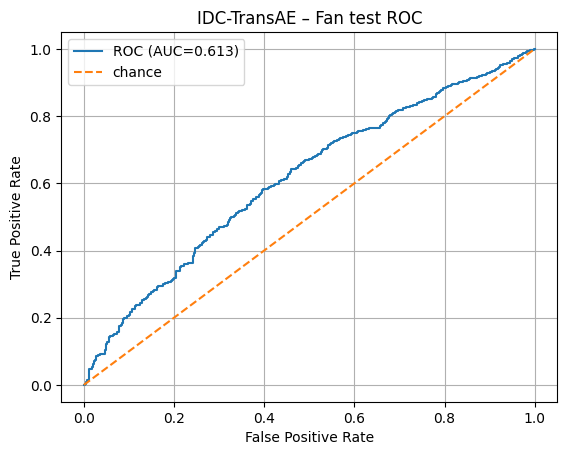

In [23]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IDC-TransAE – Fan test ROC")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
normal_scores = scores[labels == 0]
threshold_95 = np.percentile(normal_scores, 95)

print("95th percentile threshold of normal:", threshold_95)

y_pred = (scores >= threshold_95).astype(int)  # 1 = anomaly

acc  = metrics.accuracy_score(labels, y_pred)
tpr  = metrics.recall_score(labels, y_pred, pos_label=1)  # sensitivity
tnr  = metrics.recall_score(labels, y_pred, pos_label=0)  # specificity
cm   = metrics.confusion_matrix(labels, y_pred)

print("Accuracy:", acc)
print("TPR (recall anomaly):", tpr)
print("TNR (recall normal):", tnr)
print("Confusion matrix [[TN FP], [FN TP]]:")
print(cm)

95th percentile threshold of normal: 0.18777078
Accuracy: 0.2965333333333333
TPR (recall anomaly): 0.11932203389830509
TNR (recall normal): 0.95
Confusion matrix [[TN FP], [FN TP]]:
[[ 380   20]
 [1299  176]]


In [25]:
def analyze_single_file_idc(model, path, machine_id, device):
    """
    For a given audio file:
      - compute log-Mel spectrogram
      - extract patches (no randomness)
      - get center-frame reconstruction for each patch
      - build a reconstructed spectrogram on the center-frame positions
      - compute an error map

    Returns:
      spec           : (n_mels, n_frames)
      recon_spec     : (n_mels, n_centers)   [center-frame positions only]
      center_indices : list of time indices (frame indices) for each center
      error_map      : (n_mels, n_centers)   absolute error
    """
    model.eval()

    audio, sr = load_audio(path)
    spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)          # (n_mels, n_frames)

    patches = spec_to_patches(
        spec,
        patch_frames=PATCH_FRAMES,
        patch_hop=PATCH_HOP,
    )  # (n_patches, n_mels, patch_frames)

    if patches.shape[0] == 0:
        raise ValueError("No patches extracted from this file.")

    # Convert to torch tensor batch: (B, 1, n_mels, T)
    patch_tensor = torch.from_numpy(patches).float().unsqueeze(1).to(device)

    B, _, n_mels, T = patch_tensor.shape
    center_idx = get_center_index(T)

    machine_ids = torch.full(
        (B,),
        fill_value=machine_id,
        dtype=torch.long,
        device=device,
    )

    with torch.no_grad():
        recon_center, _, _ = model(
            patch_tensor,
            machine_ids,
            return_patch_errors=True,
        )  # recon_center: (B, n_mels)

    recon_center_np = recon_center.cpu().numpy().T  # (n_mels, B)

    # Target (true) center frames from original spec:
    # we need the time indices of the centers for each patch
    center_indices = []
    recon_targets = []

    n_mels, n_frames = spec.shape
    for i in range(B):
        start = i * PATCH_HOP
        c = start + center_idx
        if c >= n_frames:
            break
        center_indices.append(c)
        recon_targets.append(spec[:, c])

    recon_targets = np.stack(recon_targets, axis=1)  # (n_mels, len(center_indices))
    recon_center_np = recon_center_np[:, : len(center_indices)]

    error_map = np.abs(recon_targets - recon_center_np)  # (n_mels, len(center_indices))

    return spec, recon_center_np, center_indices, error_map

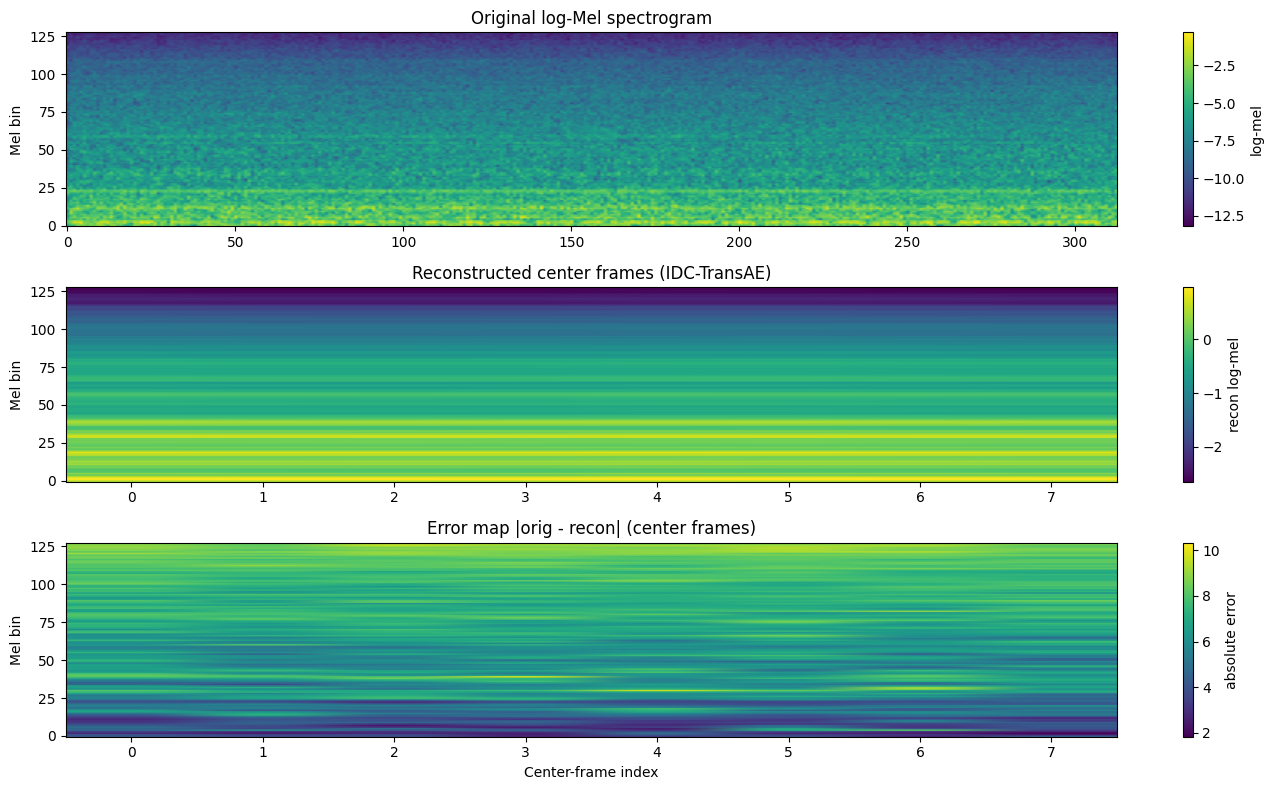

In [26]:
# Kies één anomalous file om te inspecteren
example = [
    f for f in file_list
    if f["machine_type"] == "fan" and f["split"] == "test" and f["label"] == 1
][0]

example_path = example["path"]
example_mid  = example["machine_id"]

spec, recon_spec, centers, error_map = analyze_single_file_idc(
    idc_model,
    example_path,
    example_mid,
    device,
)

# Maak tijdassen
time_all    = np.arange(spec.shape[1]) * HOP_LENGTH / SAMPLE_RATE
time_center = np.array(centers) * HOP_LENGTH / SAMPLE_RATE

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.title("Original log-Mel spectrogram")
plt.imshow(spec, origin="lower", aspect="auto")
plt.colorbar(label="log-mel")
plt.ylabel("Mel bin")

plt.subplot(3, 1, 2)
plt.title("Reconstructed center frames (IDC-TransAE)")
plt.imshow(recon_spec, origin="lower", aspect="auto")
plt.colorbar(label="recon log-mel")
plt.ylabel("Mel bin")

plt.subplot(3, 1, 3)
plt.title("Error map |orig - recon| (center frames)")
plt.imshow(error_map, origin="lower", aspect="auto")
plt.colorbar(label="absolute error")
plt.xlabel("Center-frame index")
plt.ylabel("Mel bin")

plt.tight_layout()
plt.show()